In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '.'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We will solve the folloving problem: given $x_0$ and $v_0$, find such $x(t): \mathbb{R} \to \mathbb{R}$, so that

$$\frac{\mathrm{d}^2 x}{\mathrm{d}t^2} + \zeta \omega_{0} \frac{\mathrm{d}x}{\mathrm{d}t} + \omega_{0}^{2}x = 0$$
$$x(0) = x_{0}, \frac{\mathrm{d}x}{\mathrm{d}t}(0) = v_{0}$$

Parameters $\zeta$ and $\omega_{0}$ are a physical parameters that characterize oscillation and it's damping.

We consider problem with given $\zeta = 0.2$, $\omega_{0} = 2$ and $x_0 = 5, v_0 = 7$ on a domain $[0, 10]$.

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

We know analytical solution, so we can measure actual error of our model.

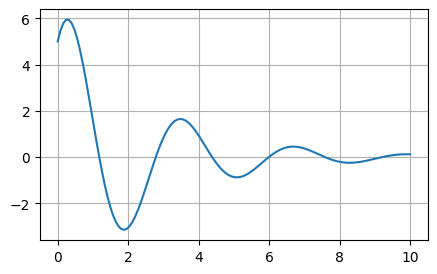

In [3]:
def analytical(t):
    return torch.exp(-0.4*t)*(4.59*torch.sin(1.96*t) + 5*torch.cos(1.96*t))

T = 10
zeta, omega = 0.2, 2.0
x0, v0 = 5.0, 7.0

t = torch.linspace(0, T, 128)
solution = analytical(t)

fig = plt.figure(figsize=(5, 3))
plt.plot(t, solution)
plt.grid()
plt.show()

Now we need to define all basic building blocks that will be used to train our model.

First of all, we need to build all of ours samplers. We can use predefined samplers if their signature satisfies all of our needs. Since initial values are just numbers and not functions or large arrays, it is reasonable to use ConstantSampler logic. For collocation points, we might choose RandomSampler. For test points, let's use ConstantSampler.

If you want, for example, load data from disk or sample it from some function, or make signatures easier, you should define your own sampler. Also you can always redefine training logic and make your own Trainer, if it is really necessary (and it should not be so hard).

In [4]:
from pinns import Domain
from pinns.samplers import ConstantSampler, RandomSampler

# Constraints sampler must return tuple of tensors 
# (points, values), each of shape [num_pts, coords].
constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad = True),
    torch.tensor([x0, v0])
))

# Collocation sampler must return just tensor of shape [num_pts, coords].
domain = Domain({'t': [0, T]})
collocation_sampler = RandomSampler(domain, 2048, return_dict=False)

# Test points sampler output must have same
# structure as constraints sampler.
test_points_sampler = ConstantSampler((t.view(-1, 1), solution.view(-1, 1)))

Now we want to define loss function. For differentiation, let's use function d from our derivatives collection.

Remember that internal logic of training must be consistent with sampler output and way in what model makes predictions.

In [5]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v, a = d(x, t, orders = [1, 2])
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

And now we can define some neural network and train it using default training logic.

In [9]:
from pinns import Trainer
from pinns.models import FF
from pinns.optimizers import Adam
from pinns.metrics import l2, rel_l2, mse

pinn = FF([1] + [64] + [1], activ=nn.Tanh(), biases=True)
print(f'Model has {pinn.count_parameters()["trainable"]} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
)

trainer.train(
    num_iters=1000,
    optimizers=[(0, adam)],
    validate_every=1,
    test_sampler=test_points_sampler,
    metrics=[rel_l2],
    )

Model has 193 trainable parameters.


  0%|          | 0/1000 [00:00<?, ?it/s]

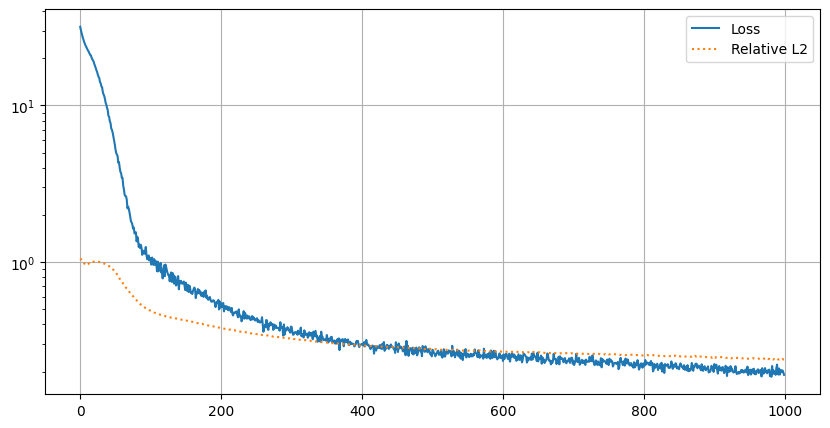

In [10]:
trainer.plot(figsize = (10, 5), error_names=['Relative L2'], single = True)

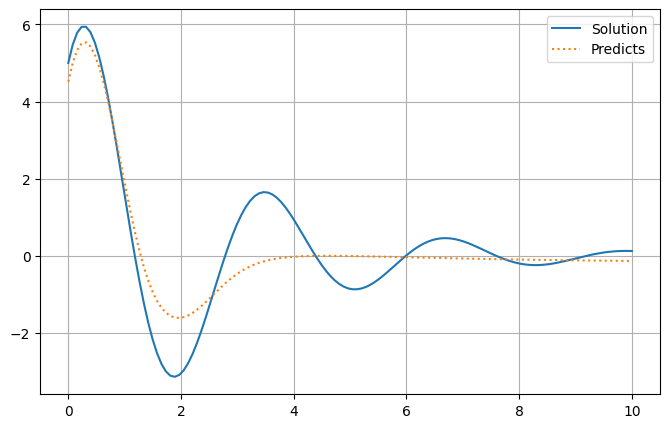

In [11]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig = plt.figure(figsize=(8, 5))

preds = pinn.predict(t.reshape(-1, 1))
plt.plot(t, solution, label='Solution')
plt.plot(t, preds.detach(), label='Predicts', linestyle=':')
plt.grid()
plt.legend()

plt.show()